In [1]:
%load_ext autoreload
%autoreload 2

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
from skipper import observe, planner

In [3]:
import sys
sys.path.append('../scripts/')

In [6]:
import sigjson_f2022b

In [10]:
obsdates = sigjson_f2022b.obsdates

In [113]:
obskeys = [ f'{x[0]:02d}-{x[1]:02d}-{x[2]:02d}' for x in obsdates[:,:3]]

In [7]:
ctio = observe.ObservingSite ()

# Observing Conditions

In [8]:
# \\ track moon altitude for each observing section

In [31]:
moondf = pd.DataFrame ( index = range(obsdates.shape[0]), columns=['illumination','maxaltitude','hours'])
for idx in range(obsdates.shape[0]):
    row = obsdates[idx]
    night_start, night_end = ctio.get_sunriseset ( row[0], row[1], row[2] )
    slot = row[3]
    # \\ break down night into the segment in which we are observing
    midpoint = night_start + 0.5*(night_end-night_start)
    if slot == 0:
        obs_start = night_start
        obs_end = night_end
    elif slot == 1:
        obs_start = night_start
        obs_end = midpoint
    elif slot == 2:
        obs_start = midpoint
        obs_end = night_end
        
    moon_illum, moon_maxaltitude = ctio.track_moon ( obs_start, obs_end )
    moondf.loc[idx, 'illumination'] = moon_illum
    moondf.loc[idx, 'maxaltitude'] = moon_maxaltitude
    moondf.loc[idx, 'hours']= (obs_end - obs_start).seconds / 3600.


In [34]:
moondf['year'] = obsdates[:,0]
moondf['month'] = obsdates[:,1]
moondf['day'] = obsdates[:,2]
moondf['slot'] = obsdates[:,3]

In [51]:
moondf['hours_s'] = moondf['hours'].apply(lambda x: '%.2f hr'%x)
moondf['illumination_s'] = moondf['illumination'].apply ( lambda x: f"{100.*x:.0f}%")
moondf['altitude_s'] = moondf['maxaltitude'].apply ( lambda x: f"{x:.1f} deg")

In [53]:
print(moondf[['year','month','day','slot', 'illumination_s','altitude_s', 'hours_s']])

    year  month  day  slot illumination_s altitude_s  hours_s
0   2022      9   20     2            20%   10.9 deg  4.93 hr
1   2022      9   21     2            13%    4.6 deg  4.92 hr
2   2022      9   22     2             7%    0.0 deg  4.91 hr
3   2022      9   23     2             3%    0.0 deg  4.89 hr
4   2022      9   27     0             6%   10.0 deg  9.65 hr
5   2022      9   28     0            12%   22.6 deg  9.62 hr
6   2022      9   29     0            20%   35.3 deg  9.58 hr
7   2022      9   30     0            30%   48.5 deg  9.55 hr
8   2022     10    2     0            52%   74.5 deg  9.48 hr
9   2022     10    3     0            64%   85.4 deg  9.47 hr
10  2022     10    4     0            74%   82.8 deg  9.42 hr


# Fall Field Progress

In [54]:
pointings_h, pointings_o = sigjson_f2022b.our_pointings.load_fallfields ()

In [55]:
coo_h = observe.CopilotOutput ( '/Users/kadofong/Downloads/db_merian.fits', pointings_h )

In [56]:
coo_o = observe.CopilotOutput ( '/Users/kadofong/Downloads/db_merian.fits', pointings_o )

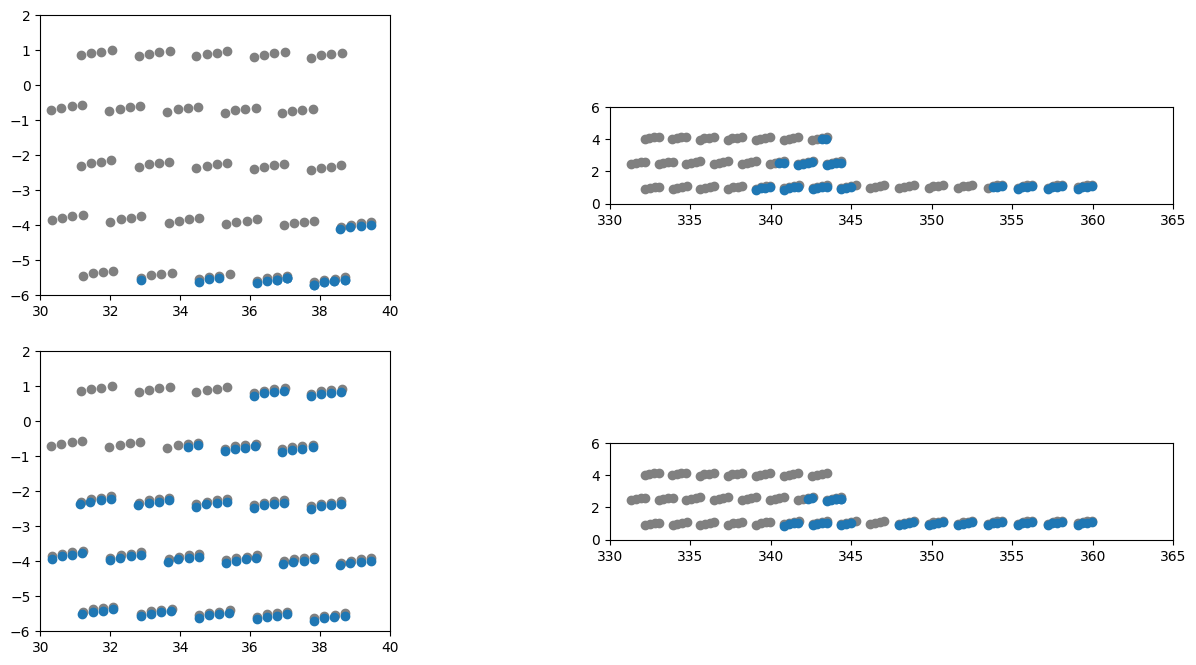

In [107]:
fig, faxarr = plt.subplots(2,2,figsize=(16,8))

for idx in range(2):
    axarr = faxarr[idx]
    cpt = [pointings_h,pointings_o][idx]
    ccoo = [coo_h,coo_o][idx]
    for ax in axarr:
        ax.set_aspect('equal')
        ax.scatter ( cpt['RA'], cpt['dec'], color='grey')
        ax.scatter ( ccoo.merian_sidecar['racenter'], ccoo.merian_sidecar['deccenter'])
    axarr[0].set_xlim(30,40)
    axarr[1].set_xlim(330,365)
    axarr[0].set_ylim(-6.,2.)
    axarr[1].set_ylim(0.,6.)

How many hours should we devote to OIII vs. Halpha this fall?

In [132]:
pointings_h.query('(RA>30.)&(RA<40.)').shape

(104, 15)

In [133]:
np.in1d(pointings_h.query('(RA>30.)&(RA<40.)')['object'], coo_h.merian_sidecar['object']).sum()

16

88

In [79]:
nobs_h = np.in1d(pointings_h['object'],coo_h.merian_sidecar['object']).sum()
ntot_h = pointings_h['object'].shape[0]
print(nobs_h, ntot_h, nobs_h/ntot_h)

62 232 0.2672413793103448


In [80]:
nobs_o = np.in1d(pointings_o['object'],coo_o.merian_sidecar['object']).sum()
ntot_o = pointings_o['object'].shape[0]
print(nobs_o, ntot_o, nobs_o/ntot_o)

131 232 0.5646551724137931


In [83]:
assert np.isclose(ntot_h / ntot_o,1.)

In [86]:
exptime_h = 10. # min
exptime_o = 15. # min
hrs_left_h = (ntot_h - nobs_h)*exptime_h/60.
hrs_left_o = (ntot_o - nobs_o)*exptime_o/60.

In [93]:
hrs_left_h + hrs_left_o

53.58333333333333

In [92]:
moondf['hours'].sum()*.9

77.77500000000002

In [97]:
# we usually get ~24 pointings per half night in Halpha
# in Spring ... which is Fall in Chile
(24. * exptime_h)/60.
# so we would get ~8 hours worth of exposures in a full night in North Spring
# it's currently South Spring and North Fall

4.0

In [102]:
(26.*exptime_h/60.)*9*2

78.0

In [120]:
26.5*10./15.

17.666666666666668

In [123]:
halpha_pointings_per_night = 27.*2
exptime_per_night = halpha_pointings_per_night * exptime_h

In [126]:
oiii_pointings_per_night = exptime_per_night / exptime_o

In [127]:
oiii_pointings_per_night * 4

144.0

In [129]:
(halpha_pointings_per_night - oiii_pointings_per_night)*4

72.0

# ObsScript Simulations

In [160]:
import sigjson_f2022b

In [180]:
obsdate = sigjson_f2022b.obsdates[1]

In [181]:
is_queued = sigjson_f2022b.plan_tomorrow ( obsdate[2], obsdate[1], obsdate[0], 
                              '/Users/kadofong/Downloads/tele20220310.csv',
                              '/Users/kadofong/Downloads/db_merian.fits', 
                               mfilt='N708', save=False )

[verify_synchronicity] last exposure in logs is 1087049, taken at 2022-03-11 09:22:22.530928+00:00
On 2022/9/21, we are observing None in N708
We are observing the second half of the night
5 pointings in this catalog need reobservation!


[predict] night slot: Second half
obsStart: 2022/09/22 01:36 AM Santiago
          2022/09/22 12:36 AM ET
          2022/09/21 09:36 PM PT
          2022/09/22 04:36 AM UTC
obsEnd:   2022/09/22 06:31 AM Santiago
          2022/09/22 05:31 AM ET
          2022/09/22 02:31 AM PT
          2022/09/22 09:31 AM UTC
Moon illumination is: 0.13
Moon max altitude during observation is: 4.56
[plan_night] Inferring priorities from object names


Minimum airmass available: 1.1719665889112592

==> 20220922_04, 1440.0000000000077s available
1200.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=2.0 objects
Minimum airmass available: 1.1602809423903118

==> 20220922_05, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=2.0 objects
Minimum airmass available: 1.1040977691921456

==> 20220922_06, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s filled by priority=2.0 objects
Minimum airmass available: 1.1104550498511325

==> 20220922_07, 3600.0s available
0.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
3600.0s filled by priority=2.0 objects
Minimum airmass available: 1.187079895779413

==> 20220922_08, 3600.0s available
0.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
3600.0s filled by priority=2.0 objects
Minimum airmass availabl

Next script for [g, 5min] is ../json/backup_scripts/SXDS/5min/SXDS_5minAGN_g_04.json
No back-up scripts available for [g, 90sec]
Next script for [r, 5min] is ../json/backup_scripts/SXDS/5min/SXDS_5minAGN_r_02.json
No back-up scripts available for [r, 90sec]
=== COSMOS ===
Next script for [g, 5min] is ../json/backup_scripts/COSMOS/5min/COSMOS_5minAGN_g_08.json
Next script for [g, 90sec] is ../json/backup_scripts/COSMOS/90sec/COSMOS_90secAGN_g_02.json
Next script for [r, 5min] is ../json/backup_scripts/COSMOS/5min/COSMOS_5minAGN_r_05.json
Next script for [r, 90sec] is ../json/backup_scripts/COSMOS/90sec/COSMOS_90secAGN_r_01.json
=== GH14 ===
No back-up scripts available for [g, 5min]
Next script for [g, 90sec] is ../json/backup_scripts/GH14/90sec/GH14_90secAGN_g_01.json
No back-up scripts available for [r, 5min]
No back-up scripts available for [r, 90sec]
=== NSA15235 ===
No back-up scripts available for [g, 5min]
No back-up scripts available for [g, 90sec]
No back-up scripts available f

In [218]:
mobs[['RA','dec']]

,RA,dec
object.1,,
VVDS_J235109.28+010756.84_N708,357.788668,1.132456
VVDS_J235219.94+011057.49_N708,358.083092,1.182638
VVDS_J233357.12+005936.77_N708,353.488017,0.993549
VVDS_J232744.22+010421.31_N708,351.934277,1.072586
VVDS_J232854.86+010722.41_N708,352.228598,1.122894
VVDS_J233005.50+011023.66_N708,352.522924,1.173241
VVDS_J225506.02+023127.06_N708,343.775111,2.524185
VVDS_J225616.58+023425.70_N708,344.069084,2.573806
VVDS_J225727.13+023724.74_N708,344.363066,2.623540


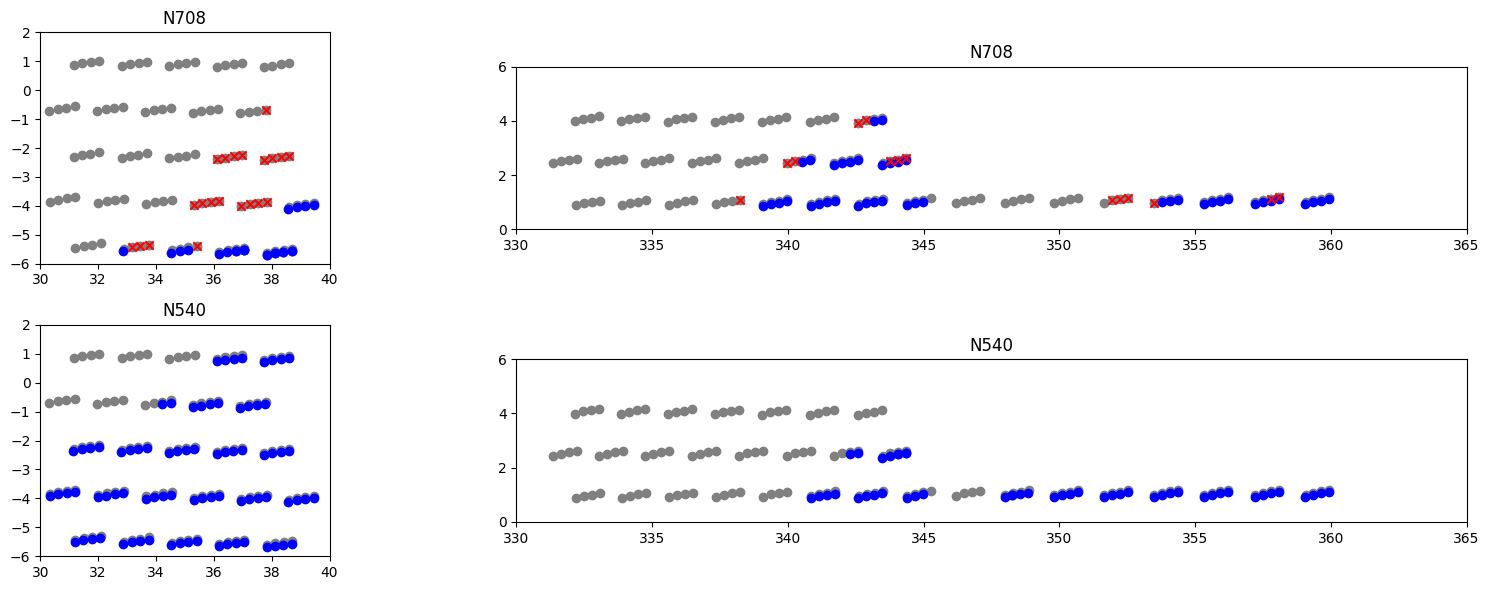

In [227]:
fig, faxarr = plt.subplots(2,2,figsize=(12*1.5,4*1.5))
show_fov = False

for idx in range(2):
    axarr = faxarr[idx]

    name = ['N708', 'N540'][idx]
    cpt = [pointings_h,pointings_o][idx]
    ccoo = [coo_h,coo_o][idx]    
    for ax in axarr:
        ax.set_aspect('equal')
      
        ax.scatter ( cpt['RA'], cpt['dec'], color='grey')
        ax.scatter ( ccoo.merian_sidecar['racenter'], ccoo.merian_sidecar['deccenter'], color='b')          
        
        if show_fov:
            for name, row in cpt.iterrows():
                circle = patches.Circle( (row['RA'], row['dec']), 1.1, facecolor='None', edgecolor='grey', )
                ax.add_patch(circle)            
            for name, row in ccoo.merian_sidecar.iterrows():
                circle = patches.Circle( (row['racenter'], row['deccenter']), 1.1, facecolor='None', edgecolor='b', )
                ax.add_patch(circle)        
        ax.set_title(name)
        
    axarr[0].set_xlim(30,40)
    axarr[1].set_xlim(330,365)
    axarr[0].set_ylim(-6.,2.)
    axarr[1].set_ylim(0.,6.)
    
    
mobs = pointings_h.loc[is_queued['is_queued']&~is_queued['qstamp'].isna()]
faxarr[0,0].scatter ( mobs['RA'], mobs['dec'], color='r', marker='x' )
faxarr[0,1].scatter ( mobs['RA'], mobs['dec'], color='r', marker='x' )
plt.tight_layout ()